In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.env.pendulum_env import PendulumEnv
from src.dataset.dynamics_dataset import DynamicsDataset
from src.model.dynamics_model import DirectDynamicsModel, ResidualDynamicsModel
from collect_data import collect_data
from train_model import train_model, eval_model

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["figure.dpi"] = 100

In [4]:
# Create environment
# env = PendulumEnv()
# Collect data
dataset = torch.load("dynamics_dataset.pt", weights_only=False)
print(f"Collected {len(dataset)} samples.")

Collected 1000 samples.


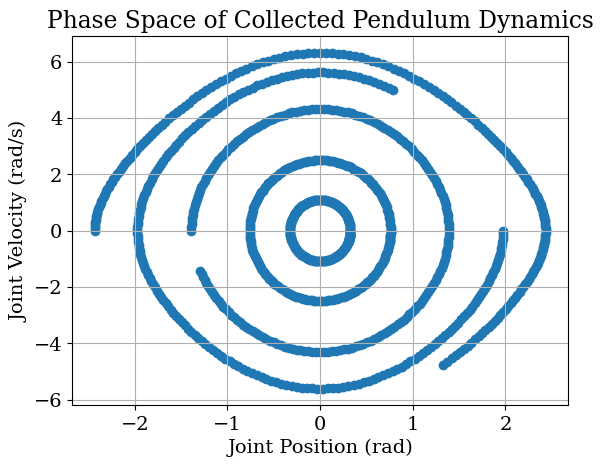

In [5]:
joint_pos = dataset.states[:, 0].numpy()
joint_vel = dataset.states[:, 1].numpy()

plt.scatter(joint_pos, joint_vel)
plt.xlabel("Joint Position (rad)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Phase Space of Collected Pendulum Dynamics")
plt.grid()
plt.show()

In [6]:
# Load trained models
direct_model = DirectDynamicsModel(state_dim=2, action_dim=1, hidden_dim=64)
direct_model.load_state_dict(torch.load("direct_dynamics_model.pt"))
residual_model = ResidualDynamicsModel(state_dim=2, action_dim=1, hidden_dim=64)
residual_model.load_state_dict(torch.load("residual_dynamics_model.pt"))

<All keys matched successfully>

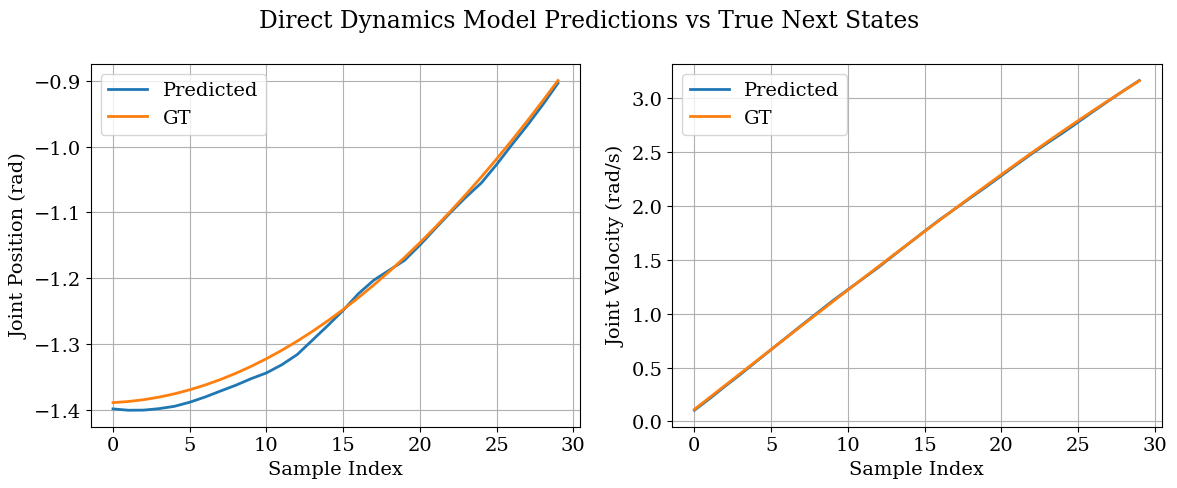

In [7]:
with torch.no_grad():
    pred_state = direct_model(dataset.states, dataset.actions)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(pred_state[:30, 0].numpy(), label="Predicted")
ax[0].plot(dataset.next_states[:30, 0].numpy(), label="GT")
ax[0].legend()
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel("Joint Position (rad)")
ax[0].grid()
ax[1].plot(pred_state[:30, 1].numpy(), label="Predicted")
ax[1].plot(dataset.next_states[:30, 1].numpy(), label="GT")
ax[1].legend()
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Joint Velocity (rad/s)")
ax[1].grid()
fig.suptitle("Direct Dynamics Model Predictions vs True Next States")
plt.tight_layout()
plt.show()

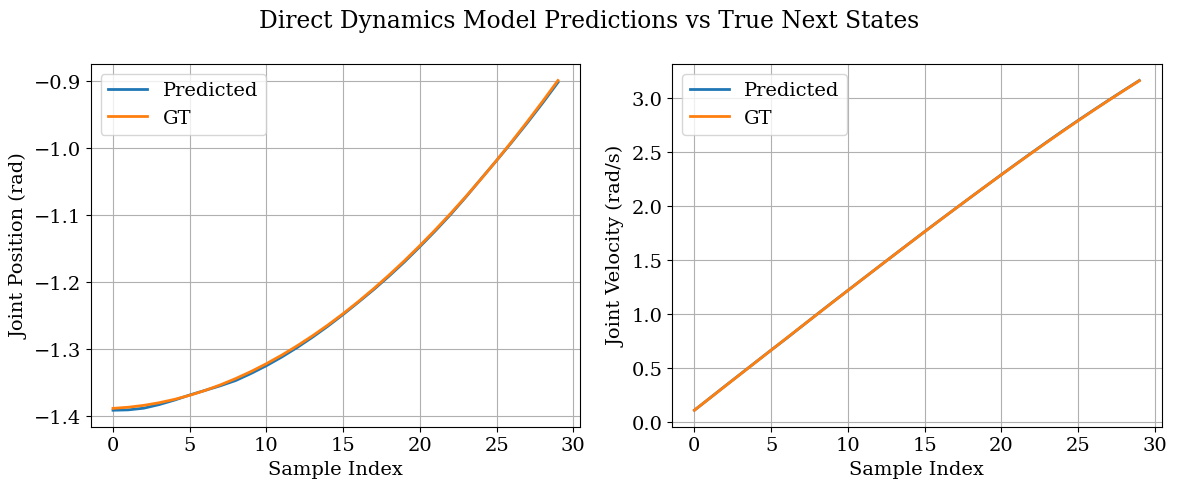

In [8]:
with torch.no_grad():
    pred_state = residual_model(dataset.states, dataset.actions)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(pred_state[:30, 0].numpy(), label="Predicted")
ax[0].plot(dataset.next_states[:30, 0].numpy(), label="GT")
ax[0].legend()
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel("Joint Position (rad)")
ax[0].grid()
ax[1].plot(pred_state[:30, 1].numpy(), label="Predicted")
ax[1].plot(dataset.next_states[:30, 1].numpy(), label="GT")
ax[1].legend()
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Joint Velocity (rad/s)")
ax[1].grid()
fig.suptitle("Direct Dynamics Model Predictions vs True Next States")
plt.tight_layout()
plt.show()

In [9]:
%%capture
# Load dataset
dataset = torch.load("dynamics_dataset.pt", weights_only=False)
print(f"Loaded dataset with {len(dataset)} samples.")

# Split dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

direct_model = DirectDynamicsModel(2, 1)
direct_loss_log = train_model(direct_model, train_dataset, num_epochs=50, batch_size=32, learning_rate=1e-3)

residual_model = ResidualDynamicsModel(2, 1)
residual_loss_log = train_model(residual_model, train_dataset, num_epochs=50, batch_size=32, learning_rate=1e-3)

Min Direct Model Training Loss: 0.000132
Min Residual Model Training Loss: 0.000006


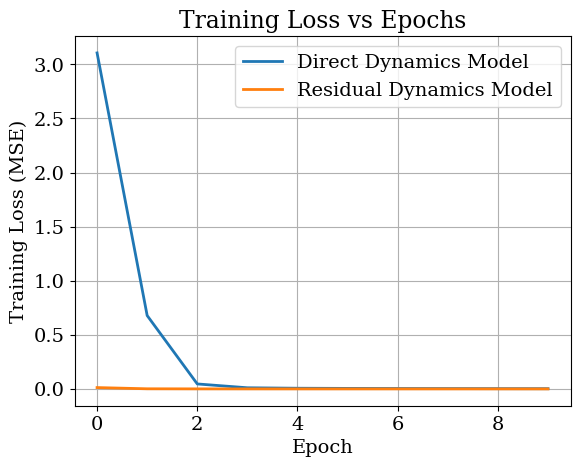

In [10]:
print(f"Min Direct Model Training Loss: {min(direct_loss_log):.6f}")
print(f"Min Residual Model Training Loss: {min(residual_loss_log):.6f}")
# Plot training loss logs
plt.plot(direct_loss_log[:10], label="Direct Dynamics Model")
plt.plot(residual_loss_log[:10], label="Residual Dynamics Model")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()